In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import cumulative_trapezoid, cumulative_simpson
import scipy.optimize as optimize

import src.astrocal.cpi as cpi

### Definition and artifical test

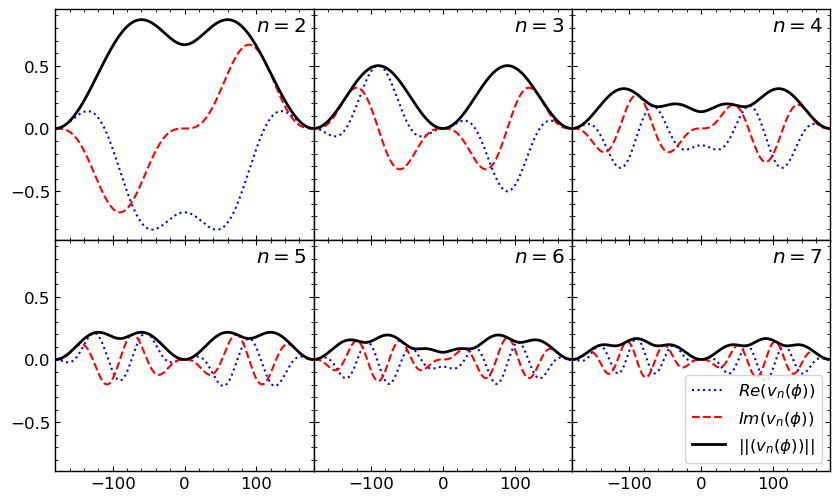

In [2]:
phi = np.linspace(-180,180,360)
phi_rad = np.deg2rad(phi)

fig, axs = plt.subplots(2,3,figsize=(10,6), sharex=True, sharey=True, gridspec_kw={'hspace':0, 'wspace':0})
for i,ax in enumerate(axs.flatten()):
    v = cpi.v_func(i+2, phi_rad)
    ax.plot(phi, np.real(v), c='b', ls=':', label='$Re(v_n(\phi))$')
    ax.plot(phi, np.imag(v), c='r', ls='--', label='$Im(v_n(\phi))$')
    ax.plot(phi, np.abs(v), lw=2, c='k', label='$||(v_n(\phi))||$')
    ax.text(0.97,0.97,f'$n={i+2}$', transform=ax.transAxes, size='x-large', ha='right', va='top')
    ax.set_xlim(-180,180)
    if i==len(axs.flatten())-1:
        ax.legend(loc='lower right', fontsize='large')
plt.show()

In [3]:
N = 50
t = np.linspace(0,360*(1-1/N),N)
r = np.zeros_like(t)
# r[(t>=60)&(t<=240)] = 0.5
r = 1+1*np.cos(3*np.deg2rad(t))+1*np.cos(np.deg2rad(t+20))**2
sun_angle = np.deg2rad(30)
psi = np.pi-sun_angle

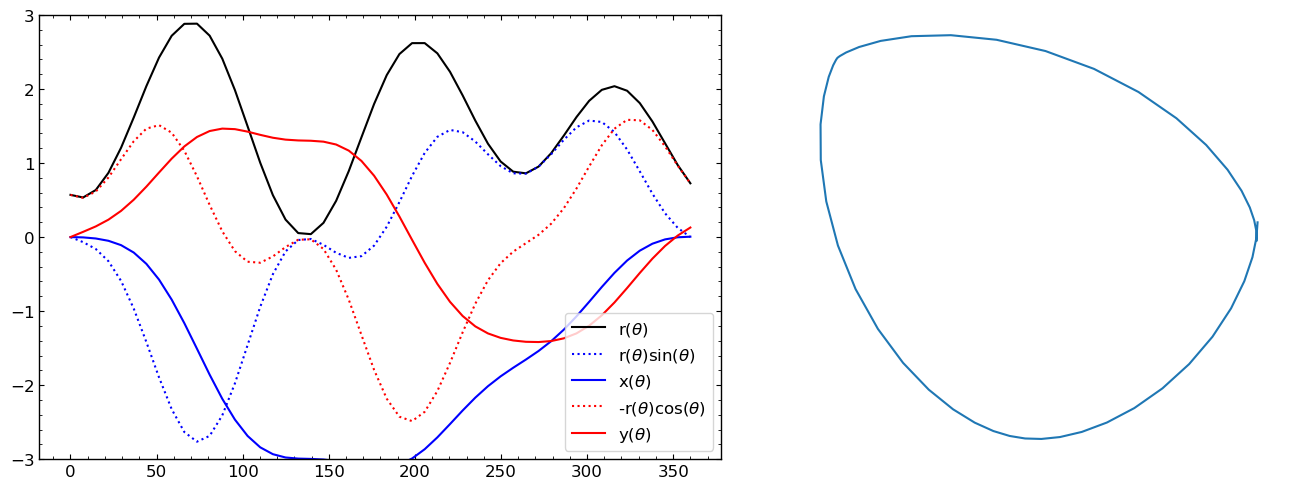

In [4]:
phase = np.linspace(0,2*np.pi,len(r))
roll_r = np.roll(r,10)
x_integrand = -roll_r*np.sin(phase)
x = cumulative_trapezoid(x_integrand, x=phase, initial=0)
y_integrand = roll_r*np.cos(phase)
y = cumulative_trapezoid(y_integrand, x=phase, initial=0)
fig, axs = plt.subplots(1,2,figsize=(14,5))
axs[0].plot(np.rad2deg(phase), roll_r, c='k', label=r"r($\theta$)")
axs[0].plot(np.rad2deg(phase), x_integrand, c='b', ls=':', label=r"r($\theta$)$\sin(\theta)$")
axs[0].plot(np.rad2deg(phase), x, c='b', label=r"x($\theta$)")
axs[0].plot(np.rad2deg(phase), y_integrand, c='r', ls=':', label=r"-r($\theta$)$\cos(\theta)$")
axs[0].plot(np.rad2deg(phase), y, c='r', label=r"y($\theta$)")
axs[0].set_ylim(-3,3)
axs[0].legend()
cpi.plot_from_radius(roll_r, ax=axs[1])
fig.tight_layout()
plt.show()

d_1  : (-2.886579864025407e-17-4.4408920985006264e-17j)
d_-1 : (-1.1470123975675187e-17+2.4184154851494516e-17j)


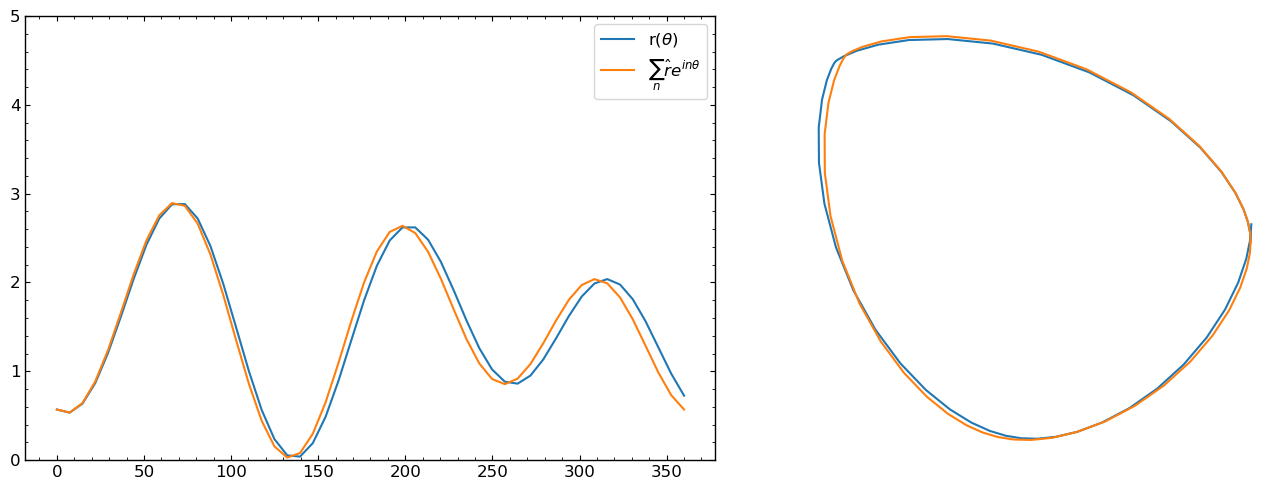

In [5]:
r_fft = np.fft.fft(roll_r)/len(roll_r)
print(f"d_1  : {r_fft[1]}")
print(f"d_-1 : {r_fft[-1]}")
r_fft[1] *= 0
r_fft[-1] *= 0
M = 10
# roll_r_sum = cpi.sum_fft(cpi.cut_fft(r_fft, M), phase)
roll_r_sum = cpi.sum_fft(r_fft, phase)

fig, axs = plt.subplots(1,2,figsize=(14,5))
axs[0].plot(np.rad2deg(phase), roll_r, c='tab:blue', label=r"r($\theta$)")
axs[0].plot(np.rad2deg(phase), roll_r_sum, c='tab:orange', label=r"$\sum_n \hat{r} e^{in\theta}$")
axs[0].set_ylim(0,5)
axs[0].legend()
cpi.plot_from_radius(roll_r, ax=axs[1])
cpi.plot_from_radius(roll_r_sum, ax=axs[1])
# axs[1].set_xlim(-1e-1,1e-1)
# axs[1].set_ylim(-1e-1,1e-1)
fig.tight_layout()
plt.show()

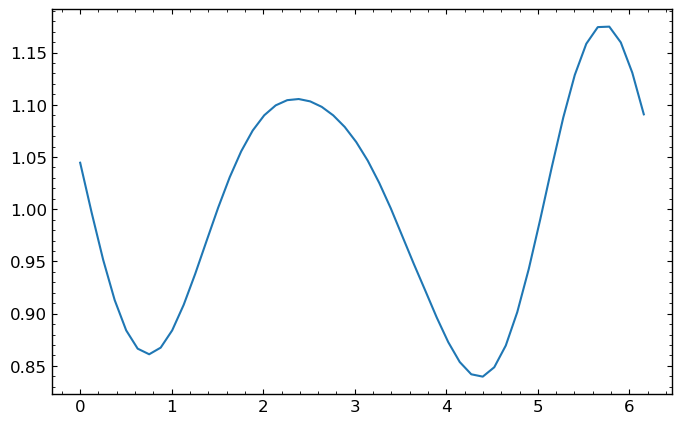

In [6]:
theta, I = cpi.radius2light_curve(roll_r_sum/np.mean(roll_r_sum), sun_angle)

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(theta, I)
plt.show()

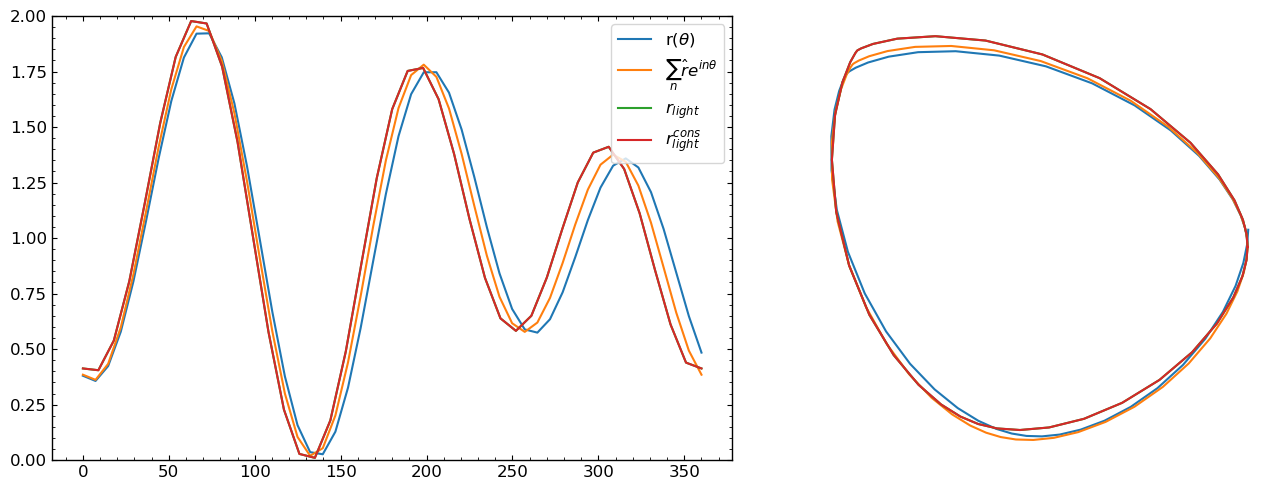

In [7]:
theta, r_I = cpi.light_curve2radius(I, sun_angle, harmonics=20)
theta, r_I_cons, res = cpi.light_curve2radius_cons(I, sun_angle, harmonics=20, return_res=True)

fig, axs = plt.subplots(1,2,figsize=(14,5))
axs[0].plot(np.rad2deg(phase), roll_r/np.mean(roll_r), c='tab:blue', label=r"r($\theta$)")
axs[0].plot(np.rad2deg(phase), roll_r_sum/np.mean(roll_r_sum), c='tab:orange', label=r"$\sum_n \hat{r} e^{in\theta}$")
axs[0].plot(np.rad2deg(theta), r_I, c='tab:green', label=r"$r_{light}$")
axs[0].plot(np.rad2deg(theta), r_I_cons, c='tab:red', label=r"$r_{light}^{cons}$")
axs[0].set_ylim(0,2)
axs[0].legend()
cpi.plot_from_radius(roll_r/np.mean(roll_r), ax=axs[1])
cpi.plot_from_radius(roll_r_sum/np.mean(roll_r_sum), ax=axs[1])
cpi.plot_from_radius(r_I, ax=axs[1])
cpi.plot_from_radius(r_I_cons, ax=axs[1])
# axs[1].set_xlim(-1e-1,1e-1)
# axs[1].set_ylim(-1e-1,1e-1)
fig.tight_layout()
plt.show()

In [8]:
res

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.5666870362094136
       x: [ 2.679e+01  0.000e+00 ...  4.261e+00  0.000e+00]
     nit: 11
     jac: [ 1.043e-07  5.671e-01 ...  5.439e-07 -3.375e-02]
    nfev: 924
    njev: 11

### Test on litterature examples

C:\Users\aurel\AppData\Local\Temp\ipykernel_13044\3420650798.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  data = pd.read_csv("281-Lucretia.csv", delimiter=", ")


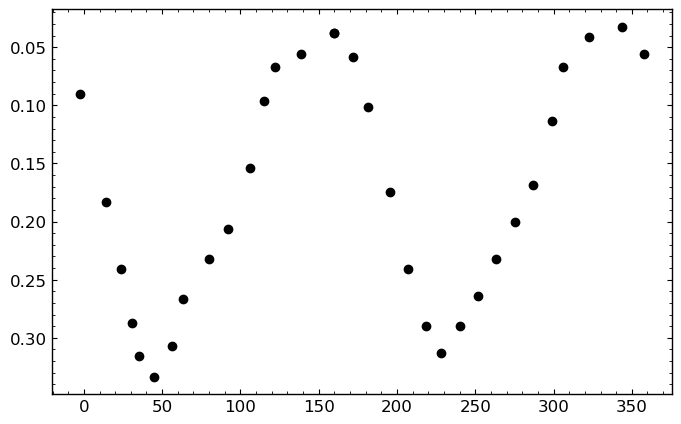

In [9]:
data = pd.read_csv("281-Lucretia.csv", delimiter=", ")

fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(data['x'], data['y'], c='k')
ax.invert_yaxis()
plt.show()

In [10]:
phase = np.linspace(0,360,100)
flux = 10**(-0.4*np.interp(phase, data['x'], data['y']))
flux = flux/np.mean(flux)

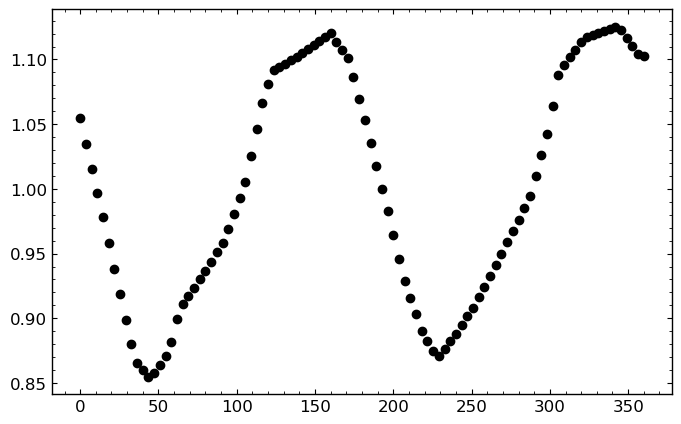

In [11]:
fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(phase, flux, c='k')
plt.show()

In [12]:
sun_angle = np.deg2rad(7)
psi = np.pi - sun_angle
theta, r = cpi.light_curve2radius_cons(flux, sun_angle=sun_angle, harmonics=None)
# r[r<0] = 0

C:\Users\aurel\AppData\Local\Temp\ipykernel_13044\1701959173.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


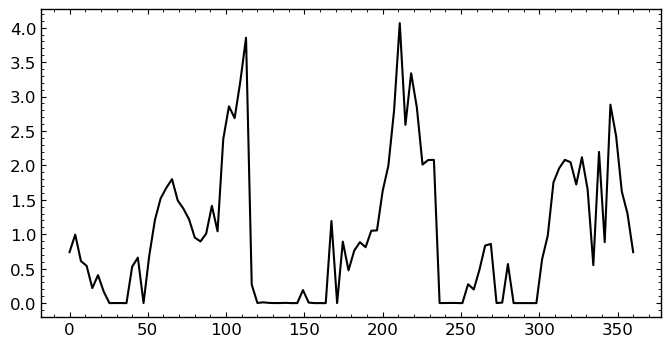

In [13]:
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(np.rad2deg(theta), r, c='k')
fig.show()

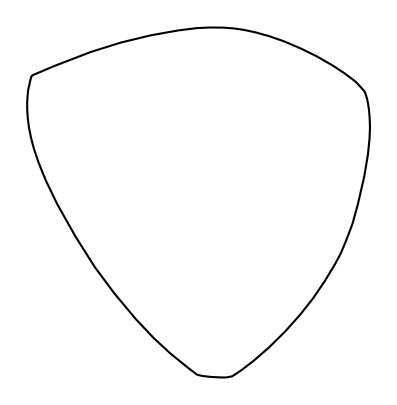

In [14]:
cpi.plot_from_radius(r, color='k')

C:\Users\aurel\AppData\Local\Temp\ipykernel_13044\1703389157.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


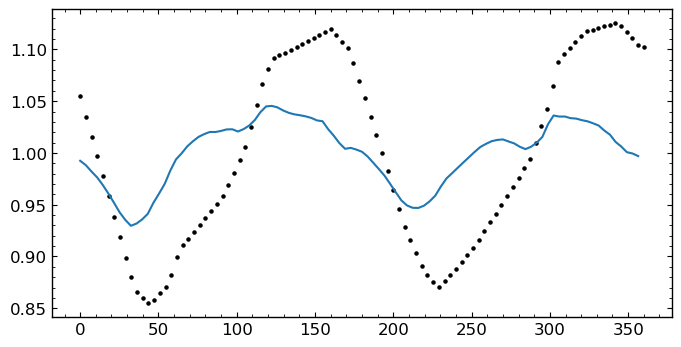

In [15]:
theta, I = cpi.radius2light_curve(r, sun_angle=sun_angle)
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(np.rad2deg(theta), I)
ax.scatter(phase, flux, color='k', s=5)
fig.show()